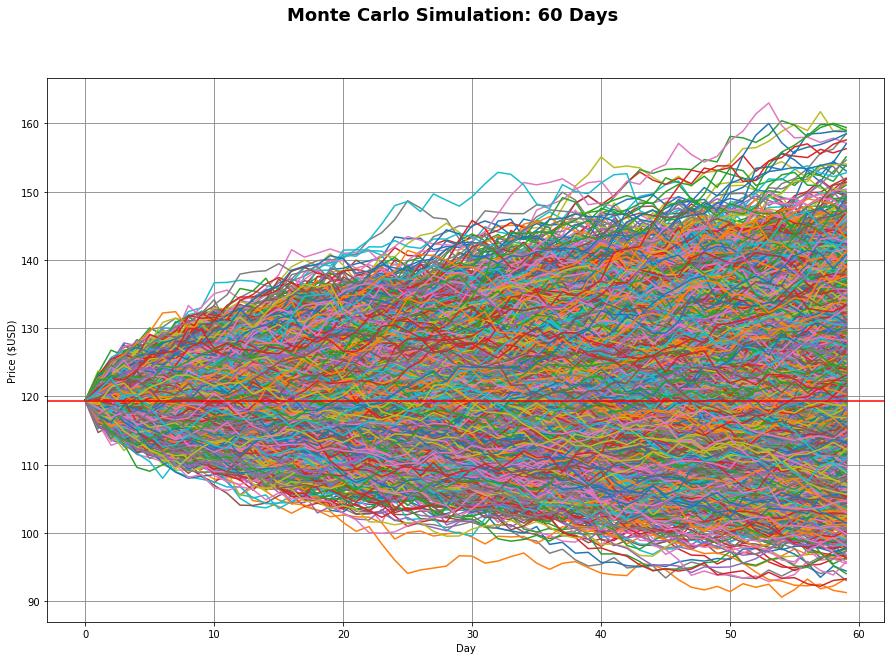

119.31999969482422


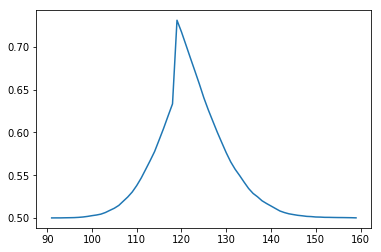

('Max/Min', 159.3903334980918, 91.23144452910911)
{120: 0.013659690408368452, 121: 0.015231108812249428, 122: 0.015382777371830247, 123: 0.015100870550875722, 124: 0.015313585892158699, 125: 0.016061021290513233, 126: 0.014190117545733849, 118: 0.0978401351391297, 117: 0.01424119068616947, 116: 0.014520044986189529, 127: 0.01306144954270605, 128: 0.012959233001958892, 129: 0.01209751650888402, 130: 0.011946941005065104, 131: 0.010679027306302658, 132: 0.008712454091060695, 133: 0.007314609593688126, 115: 0.01353981249641989, 114: 0.013414602421653266, 113: 0.010711226391674655, 134: 0.007728204170090125, 135: 0.007386319105620043, 136: 0.005766521559733784, 137: 0.003980488724180886, 138: 0.0046204281358563914, 139: 0.0031881107581442913, 140: 0.002910097793411004, 112: 0.010247248968896838, 111: 0.010126846509517007, 110: 0.008767008592373338, 141: 0.0029507203960088546, 142: 0.002911437060640787, 143: 0.0018348356049491255, 144: 0.001436052697479484, 145: 0.0009175120350582988, 146: 

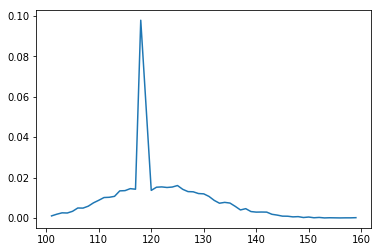

In [61]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
import requests
import json
%matplotlib inline


def monte_carlo(symbol):
    ticker = symbol 
    data = pd.DataFrame()
    data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2009-1-1')['Adj Close']

    log_returns = np.log(1 + data.pct_change())
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()

    t_intervals = 60
    iterations = 10000
    daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

    S0 = data.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0

    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]

    fig = plt.figure(figsize=(15,10))
    title = "Monte Carlo Simulation: " + str(t_intervals) + " Days"
    plt.plot(price_list)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Price ($USD)')
    plt.grid(True,color='grey')
    plt.axhline(y=data.iloc[-1].values[0], color='r', linestyle='-')
    plt.show()
    print(data.iloc[-1].values[0])
    return price_list

def find_prob(price_list, input_price, day):
    prob_list = price_list[day, :] #Price list is 60x100, we are inspecting the prices on the 60th day for prob of a certain price on the 60th day
    count = 0
    for item in prob_list:
        if item > input_price:
            count = count + 1
    return count/len(prob_list)
    
# Following code makes relevant tokens necessary to conduct TD ameritrade activities on behalf of my account
# Note refresh token is valid for 90 days. It is used to generate auth token which is only valid for 30 mins
def get_auth_token():
    refresh_token = 'sXtUVLkSa8gbLhTjgVRPJDkx0J2khZOwk6uN+q0KlnrLoNuz6Fnm893VKp76zqml0GWZ73K1Oler9JJYMNFxziNe58G+SQ5zLgqLdA3EXVO3FXIPSR74glOqGddJ2hKH9tXL1oWft5WCE6ZUpq/zjPhsJSBPi8yGx2RnSABUc7FMqTeYOUcBztjjCUl4/jgk2F076hyrrDCSBX/yakGHA09jHcbQZOOl8vyrxu/UfrjEgfxNi4YuEMKz23pcHd2L77dJRBMTugYYnFzRpHMHdGukWedlgOO4/RgQgsZ3nAKEFrSYUS9XrugrREalD2Ufo+onBbkr+N1EP+BEyinufwOkrwsebgw/5FQKB9fJzbNw/79nXeS0ZG4OHlHA3shPP6JbJOUeh2Fwev/yuhrE6sGwfcdvftzn8vFTe52KGJrBe5RapEb+n+DxkJm100MQuG4LYrgoVi/JHHvlrueqQYnI53tYFD84wI4dnFH19sX584k0XZTqmBn4M2JDQqiO4SRIMAOVtkogDmlhOHMo1xDZVUG1aDRSdnoXe3EbnfnYI8h/PfIRyBUeVolmaUDfR5KUQ7etO7BMYlfC4w0hKhbcl1HayMZLi9lgtCPqW2cjoonhrywNt+TjlwG1zwxdfBL+T2YJmyb4jGYKe3r+/LfVV/Mo73zzodDajQtkCLjbtCcGPs8SrETi73eslhHuVxhUs73PBJBhwQAnwFXy1WsgNHANr3M733dxb/kJqlSkJTTN416SeuMuu69pM8j/T7AW1+Ly/d4OVjiIhpp5ZlU9U9YrSVdSQtD9A3Tt/VHI3jIHNn0yDMyweZlwfzzHKXDVEemNXPWXu3iGj/VZqujZ3RL0ZnpNHbQDf8PX+LjkY+0e7HteljkhgZlg4X0Q5F4YySluQCE=212FD3x19z9sWBHDJACbC00B75E'
    auth_params = {'grant_type':'refresh_token', 'refresh_token':refresh_token, 'client_id':'TESTAUTH122@AMER.OAUTHAP'}
    auth_api_url = 'https://api.tdameritrade.com/v1/oauth2/token'
    return "Bearer "+ requests.post(auth_api_url, data=auth_params).json()['access_token']


# Following code will get the option chain data using the authorized token
# Parameters: call_or_put: 'CALL'/'PUT'; symbol: string with stock symbol from passed in stock list
def get_raw_option_data(call_or_put, symbol):
    url = 'https://api.tdameritrade.com/v1/marketdata/chains'
    strike_count = '50000000' #need to figure out how to get ALL or just use an arbitraliy huge num
    strategy = 'SINGLE'
    authorization_header = {'Authorization': get_auth_token()}
    if call_or_put == 'CALL':
        pay = {'symbol':symbol,'strikeCount':strike_count, 'strategy':strategy, 'contractType': 'CALL'}
    elif call_or_put == 'PUT':
        pay = {'symbol':symbol,'strikeCount':strike_count, 'strategy':strategy, 'contractType': 'PUT'}
    return [requests.get(url, params = pay, headers = authorization_header).json()['callExpDateMap'], requests.get(url, params = pay, headers = authorization_header).json()['underlyingPrice']]

       
    
def preprocess_probs(price_list, selected_day, stock_price):
    prob_list = price_list[selected_day, :]
    min_price = min(prob_list)
    max_price = max(prob_list)
    prob_dic = {}
    for price in range(int(min_price), int(max_price+1)):
        count = 0
        for item in prob_list:
            if price < stock_price:
                if item < price:
                    count = count + 1 
            else:
                if item > price:
                    count = count + 1
        prob_dic[price] = count/len(prob_list)
    x, y = zip(*prob_dic.items())
    plt.plot(x, norm.cdf(y))
    plt.show()
    #y_sum = sum(y)
    #y = tuple([i / y_sum for i in y])
    #print(sum(y))
    #plt.plot(x, y)
    #plt.show()
    print(("Max/Min", max_price, min_price))
    return (dict(zip(x, tuple(norm.cdf(y)))), max_price, min_price)

def create_prob_bins(monte_carlo_results, selected_day, bullish_frac, bearish_frac, stock_price):
    results = preprocess_probs(monte_carlo_results, selected_day, stock_price)
    prob_dic = results[0]
    max_price = results[1]
    min_price = results[2]
    prob_counter = 0
    upper = stock_price
    lower = stock_price
    prob_bin = {}
    breaking_flag = 0
    while prob_counter < 1:
        if breaking_flag == 1:
            break
        bull_count = 0
        bear_count = 0
        if bullish_frac > bearish_frac:
            while bull_count < (bullish_frac*10) and prob_counter < 1 and breaking_flag != 1:
                max_prob = max(prob_dic[upper+1],prob_dic[upper])
                min_prob = min(prob_dic[upper+1],prob_dic[upper])
                prob_bin[upper+1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                upper = upper + 1
                if upper+1 > max_price:
                    breaking_flag = 1
                bull_count = bull_count + 1
            while bear_count < (bearish_frac*10) and prob_counter < 1:
                max_prob = max(prob_dic[lower],prob_dic[lower - 1])
                min_prob = min(prob_dic[lower],prob_dic[lower - 1])
                prob_bin[lower-1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                lower = lower - 1
                bear_count = bear_count + 1
        else:
            while bear_count < (bearish_frac*10) and prob_counter < 1 and breaking_flag != 1:
                max_prob = max(prob_dic[lower],prob_dic[lower - 1])
                min_prob = min(prob_dic[lower],prob_dic[lower - 1])
                prob_bin[lower-1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                lower = lower - 1
                if lower-1 < min_price:
                    breaking_flag = 1
                bear_count = bear_count + 1
            while bull_count < (bullish_frac*10) and prob_counter < 1:
                max_prob = max(prob_dic[upper+1],prob_dic[upper])
                min_prob = min(prob_dic[upper+1],prob_dic[upper])
                prob_bin[upper+1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                upper = upper + 1
                bull_count = bull_count + 1
    print(prob_bin)
    x, y = zip(*sorted(prob_bin.items()))
    plt.plot(x, y)
    plt.show()
    return prob_bin
        

        
        
def processing(symbol, call_or_put, monte_carlo_results):
    data = get_raw_option_data(call_or_put, symbol)
    agg_data = {}
    date_keys = []
    for (k,v) in data[0].items():
        date_keys.append([k,list(v.keys())])
        agg_data[k] = v
    print(agg_data[date_keys[0][0]][date_keys[0][1][0]][0]['putCall']) #This is an example of how we can access data. Can make less complicated if necessary using a different data structure but this should be good enough performace-wise
    target_list = []
    stock_price = data[1]
    if call_or_put == "CALL":
        for i in range(0,len(date_keys)):
            for j in range(0, len(date_keys[i][1])):
                if agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'] < 60 :
                    target = {'symbol': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['symbol'], 
                                   'bid': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['bid'],
                                   'ask': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'],
                                   'strike': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'],
                                    'days to exp': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'],
                                  'Profit prob long call': find_prob(monte_carlo_results, agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'] + agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration']),
                                  'Profit prob short call': 1 - find_prob(monte_carlo_results, agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'] + agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'])}
                    target_list.append(target)
    if call_or_put == "PUT":
        for i in range(0,len(date_keys)):
            for j in range(0, len(date_keys[i][1])):
                if agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'] < 60 :
                    target = {'symbol': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['symbol'], 
                                   'bid': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['bid'],
                                   'ask': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'],
                                   'strike': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'],
                              'days to exp': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'],
                                  'Profit prob long put': 1 - find_prob(monte_carlo_results, agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'] - agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration']),
                                  'Profit prob short put': find_prob(monte_carlo_results, agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'] - agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'])}
                    target_list.append(target)
    df = pd.DataFrame(target_list)
    df = df.set_index('symbol', drop = True)
    return df
    
    
    
    
if __name__== "__main__":
    symbol = 'PG'
    monte_carlo_results = monte_carlo('PG')
    #print(processing(symbol, "CALL", monte_carlo_results))
    #print(find_prob(monte_carlo_results, 90, 59))
    #preprocess_carlo(monte_carlo_results, 117.31999969482422, 59)
    create_prob_bins(monte_carlo_results, 59, 0.7, 0.3, round(119.35469818115234))
    